# Test different synchronizing methods

In [20]:
import sys
import os

# Get the path to the project root (one level up from the notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root, NOT 'source', to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# print the sys.path
print(sys.path)

['/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/lenasalzmann/dev/dbs-eeg-sync/.venv/lib/python3.12/site-packages', '/Users/lenasalzmann/dev/dbs-eeg-sync', '/Users/lenasalzmann/dev/dbs-eeg-sync/source']


In [21]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, resample, savgol_filter

from source.data_loader import load_eeg_data, open_json_file, select_recording, read_time_domain_data
from source.power_calculater import compute_eeg_power

In [3]:
eeg_file = '/Users/lenasalzmann/dev/dbs-eeg-sync/data/eeg_example.set'
dbs_file = '/Users/lenasalzmann/dev/dbs-eeg-sync/data/dbs_example.json'

In [4]:
# Load EEG
eeg_data = load_eeg_data(eeg_file)
eeg_fs = eeg_data.info["sfreq"]

---
Successfully loaded /Users/lenasalzmann/dev/dbs-eeg-sync/data/eeg_example.set


In [5]:
# Load DBS
json_data = open_json_file(dbs_file)
block_num = select_recording(json_data)
dbs_data = read_time_domain_data(json_data, block_num)

---
Available DBS recordings: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
---
Reading DBS recording 0...
---
Successfully read DBS recording 0 with sampling frequency 250 Hz


In [6]:
# crop and downsample EEG data
start_time = 0
end_time = 120
eeg_data_small = eeg_data.copy().crop(tmin=start_time, tmax=end_time)
eeg_data_small.resample(500, npad="auto")

# save EEG data /Users/lenasalzmann/Downloads/eeg_example_cropped.fif
eeg_data_small.save('/Users/lenasalzmann/Downloads/eeg_example_cropped.fif', overwrite=True)


Overwriting existing file.
Writing /Users/lenasalzmann/Downloads/eeg_example_cropped.fif
Closing /Users/lenasalzmann/Downloads/eeg_example_cropped.fif
[done]


/var/folders/1_/cvx_3yt96s7gxzrkn4b55xlc0000gn/T/ipykernel_10451/1463653879.py:8: RuntimeWarning: This filename (/Users/lenasalzmann/Downloads/eeg_example_cropped.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_small.save('/Users/lenasalzmann/Downloads/eeg_example_cropped.fif', overwrite=True)


[PosixPath('/Users/lenasalzmann/Downloads/eeg_example_cropped.fif')]

## Artefact detection via Peak Finder

Functions

In [7]:
def find_eeg_peak(raw_eeg, freq_low, freq_high, decim, duration_sec=120, save_dir=None, log_file="sync_log.txt"):
    """
    Finds the highest synchronization peak index in EEG data within a specified frequency band.

    Args:
        raw_eeg (mne.io.Raw): The raw EEG data object to analyze.
        freq_low (float): Lower bound of the frequency range of interest.
        freq_high (float): Upper bound of the frequency range of interest.
        decim (int): Decimation factor for downsampling.
        duration_sec (int, optional): Duration of the cropped EEG window (default: 120 sec).
        save_dir (str, optional): Directory to save the plot. If None, the plot is not saved.
        log_file (str, optional): Path to the log file where peak detection results will be saved.

    Returns:
        int: Peak index in EEG sampling frequency.
        float: Peak time in seconds.
    """

    # Crop and filter EEG
    raw_cropped = raw_eeg.copy().crop(tmax=duration_sec) 
    raw_filtered = raw_cropped.copy().filter(l_freq=freq_low, h_freq=freq_high)  

    fs = raw_filtered.info["sfreq"]
    freqs = np.arange(freq_low, freq_high, 1)
    n_cycles = freqs / 1.5  
    time_bandwidth = 4.0  

    power = mne.time_frequency.tfr_multitaper(
        raw_filtered,
        picks="eeg",
        freqs=freqs,
        n_cycles=n_cycles,
        time_bandwidth=time_bandwidth,
        decim=decim,
        average=True,
        return_itc=False
    )

    power_band_sum = power.data.mean(axis=0).sum(axis=0)  
    time_axis = np.arange(len(power_band_sum)) * decim / fs

    # Detect peaks
    peaks, peak_properties = find_peaks(power_band_sum, height=np.mean(power_band_sum) * 1.5)

    if len(peaks) > 0:
        # Select the peak with the highest power value
        highest_peak_idx = np.argmax(peak_properties["peak_heights"])
        peak_power_idx = peaks[highest_peak_idx]
    else:
        # If no peak is found, use the maximum value in the first 1000 samples as a fallback
        peak_power_idx = np.argmax(power_band_sum[:1000])  

    eeg_peak_index_fs = peak_power_idx * decim
    eeg_peak_index_s = eeg_peak_index_fs / fs

    # Log the detected peak
    with open(log_file, "a") as log:
        log.write(f"Detected highest EEG peak at {eeg_peak_index_fs} samples ({eeg_peak_index_s:.2f} sec)\n")

    print(f"Peak time logged in {log_file}")

    # Plot the detected peak
    plt.figure(figsize=(10, 5))
    plt.plot(time_axis, power_band_sum, label="Power in Band (120-130 Hz)")
    plt.axvline(time_axis[peak_power_idx], color='r', linestyle='--', label=f'Highest Peak @ {time_axis[peak_power_idx]:.2f} sec')
    plt.xlabel('Time (s)')
    plt.ylabel('Power')
    plt.title('EEG: Power Over Time in 125 Hz Band')
    plt.legend()

    if save_dir:
        plt.savefig(f"{save_dir}/syncPeakEEG.png")
        print(f"Plot saved to {save_dir}/syncPeakEEG.png")

    plt.show()  # Ensures the plot opens
    # wait for few seconds
    plt.pause(5)
    plt.close()

    return eeg_peak_index_fs

In [8]:
def find_dbs_peak(dbs_data, save_dir=None, log_file="sync_log.txt"):
    """
    Finds the highest peak in DBS data in the positive direction only.

    Args:
        dbs_data (pd.DataFrame): The DBS time series data.
        dbs_fs (float): Sampling frequency of the DBS.
        save_dir (str, optional): Directory to save the plot. If None, the plot is not saved.
        log_file (str, optional): Log file path for saving detected peak info.

    Returns:
        int: Peak index in DBS samples.
        float: Peak time in seconds.
        pd.DataFrame: Cropped DBS data from the detected peak onward.
    """

    # Extract DBS signal
    dbs_signal = dbs_data["TimeDomainData"].values
    dbs_fs = dbs_data["SampleRateInHz"][0]

    # Compute time axis
    dbs_time_axis = np.arange(len(dbs_signal)) / dbs_fs

    # Find peaks **only in the positive direction**
    peaks, _ = find_peaks(dbs_signal, height=0)  # Only positive peaks

    if len(peaks) > 0:
        # Select the **highest** positive peak
        dbs_peak_index_fs = peaks[np.argmax(dbs_signal[peaks])]
    else:
        # Fallback: Use max value in the first 1000 samples
        dbs_peak_index_fs = np.argmax(dbs_signal[:1000])

    dbs_peak_index_s = dbs_peak_index_fs / dbs_fs

    # Log detected peak
    with open(log_file, "a") as log:
        log.write(f"Detected DBS peak at {dbs_peak_index_fs} samples ({dbs_peak_index_s:.2f} sec)\n")

    print(f"DBS peak time logged in {log_file}")

    # Plot detected peak
    plt.figure(figsize=(10, 5))
    plt.plot(dbs_time_axis, dbs_signal, label="DBS Signal")
    plt.axvline(dbs_time_axis[dbs_peak_index_fs], color='r', linestyle='--', label=f'Peak @ {dbs_peak_index_s:.2f} sec')
    plt.xlabel('Time (s)')
    plt.ylabel('DBS Amplitude')
    plt.title('DBS Peak Detection')
    plt.legend()

    if save_dir:
        plt.savefig(f"{save_dir}/syncPeakDBS.png")
        print(f"Plot saved to {save_dir}/syncPeakDBS.png")

    plt.show()
    # wait for few seconds
    plt.pause(5)
    plt.close()

    return dbs_peak_index_fs

In [9]:
def crop_data(eeg_data, dbs_data, peak_dbs_idx, peak_index_eeg_fs):
    """ 
    Crops the data at the detected peaks and resamples to match the shortest signal.

    Args:
        eeg_data (mne.io.Raw): The EEG data object.
        dbs_data (pd.DataFrame): The DBS time series data.
        peak_dbs_idx (int): Peak index in DBS samples.
        peak_index_eeg_fs (int): Peak index in EEG samples.

    Returns:
        mne.io.Raw: Cropped and resampled EEG data.
        pd.DataFrame: Cropped and resampled DBS data.    
    
    """

    cropped_eeg = eeg_data.copy().crop(tmin=peak_index_eeg_fs / eeg_data.info["sfreq"])
    cropped_dbs = dbs_data.iloc[peak_dbs_idx:].reset_index(drop=True)

    eeg_fs = eeg_data.info["sfreq"]
    dbs_fs = dbs_data["SampleRateInHz"][0]

    # check length
    print(f"Cropped EEG length: {len(cropped_eeg.times)/eeg_fs/60} minutes")
    print(f"Cropped DBS length: {len(cropped_dbs)/dbs_fs/60} minutes")

    return cropped_eeg, cropped_dbs

In [10]:
def synchronize_data(cropped_eeg, cropped_dbs, save_dir=None):
    """
    Synchronizes EEG and DBS data by resampling to the same length efficiently.

    Args:
        cropped_eeg (mne.io.Raw): EEG data (MNE object).
        cropped_dbs (pd.DataFrame): DBS data (Pandas DataFrame).
        save_dir (str, optional): Directory to save the plot.

    Returns:
        synchronized_eeg (mne.io.Raw): Resampled EEG data with updated sampling frequency.
        synchronized_dbs (pd.DataFrame): Resampled DBS data.
    """

    # Get EEG sampling rate
    eeg_fs = cropped_eeg.info["sfreq"]

    # Get DBS signal & sampling rate
    dbs_signal = cropped_dbs["TimeDomainData"].values
    dbs_fs = cropped_dbs["SampleRateInHz"].iloc[0]

    # Choose the target sampling frequency (lower one for efficiency)
    target_fs = min(eeg_fs, dbs_fs)

    # Resample EEG using MNE's built-in method
    cropped_eeg.resample(target_fs)

    # Resample DBS signal if needed
    if dbs_fs != target_fs:
        resampled_dbs_signal = resample(dbs_signal, int(len(dbs_signal) * target_fs / dbs_fs))
    else:
        resampled_dbs_signal = dbs_signal

    # Generate time vectors efficiently
    n_times = cropped_eeg.get_data().shape[1]
    eeg_times = np.linspace(0, n_times / target_fs, n_times)
    dbs_times = np.linspace(0, len(resampled_dbs_signal) / target_fs, len(resampled_dbs_signal))

    # Plot the signals
    plt.figure(figsize=(12, 5))
    plt.plot(eeg_times, cropped_eeg.get_data()[0], label="EEG Signal (Channel 0)", color='blue', alpha=0.7)
    plt.plot(dbs_times, resampled_dbs_signal, label="DBS Signal", color='orange', alpha=0.7)
    plt.axvline(0, color='r', linestyle='--', label='Detected Peak')

    plt.xlabel('Time (s)')
    plt.ylabel('Signal Amplitude')
    plt.title('Synchronized EEG & DBS Signals')
    plt.legend()

    if save_dir:
        plt.savefig(f"{save_dir}/eeg_dbs_overlay.png")
        print(f"Overlay plot saved to {save_dir}/eeg_dbs_overlay.png")

    plt.show()

    # Update DBS data
    synchronized_dbs = cropped_dbs.copy()
    synchronized_dbs["TimeDomainData"] = resampled_dbs_signal
    synchronized_dbs["SampleRateInHz"] = target_fs

    return cropped_eeg, synchronized_dbs

Apply functions

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.2e+02 - 1.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 120.00
- Lower transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 105.00 Hz)
- Upper passband edge: 130.00 Hz
- Upper transition bandwidth: 32.50 Hz (-6 dB cutoff frequency: 146.25 Hz)
- Filter length: 221 samples (0.111 s)

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
Peak time logged in sync_log.txt


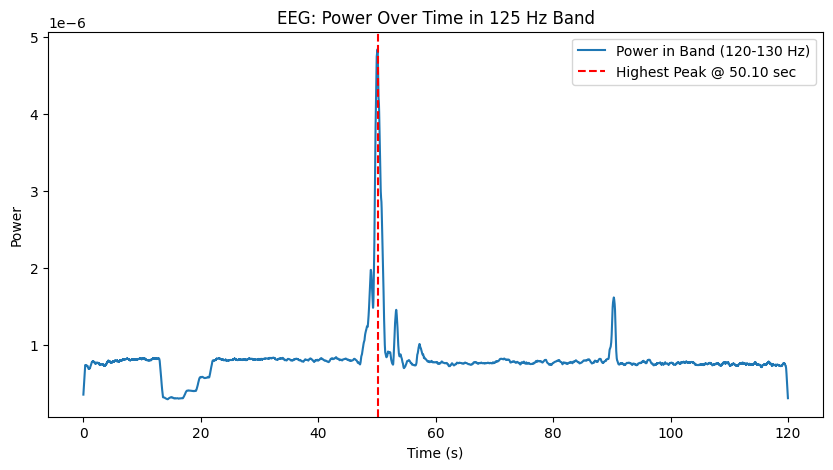

DBS peak time logged in sync_log.txt


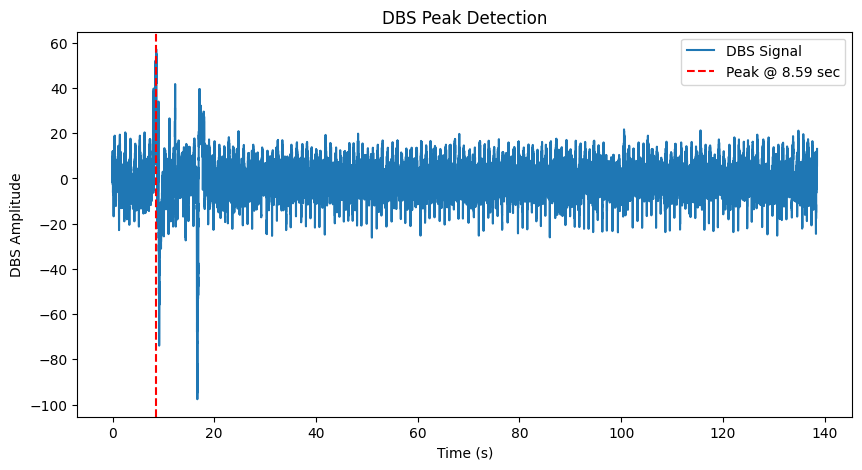

Cropped EEG length: 1.7379916666666666 minutes
Cropped DBS length: 2.165133333333333 minutes
EEG and DBS cropped at the synchronization peak.


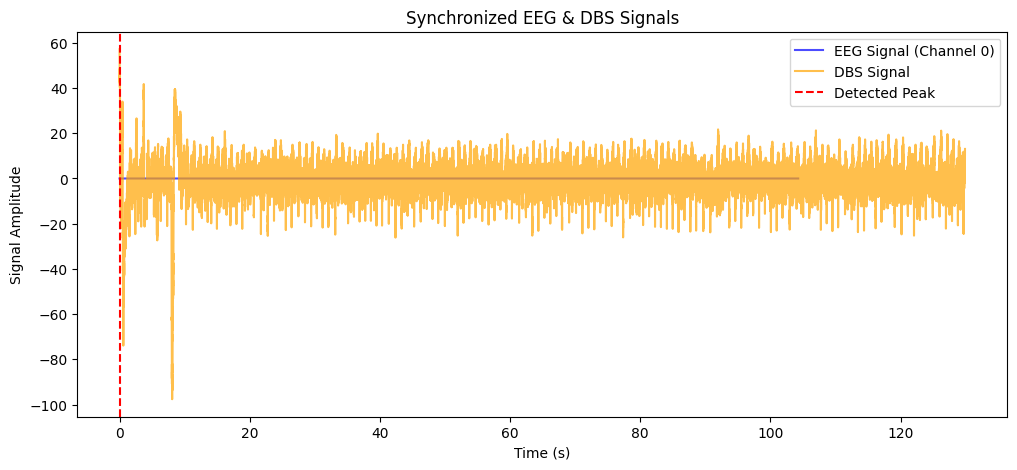

In [11]:
# Find EEG peak
eeg_peak_fs = find_eeg_peak(eeg_data, 120, 130, 4, duration_sec=120)
# Find DBS peak
dbs_peak_fs = find_dbs_peak(dbs_data)
# Synchronize EEG and cropped DBS
cropped_eeg, cropped_dbs = crop_data(eeg_data, dbs_data, dbs_peak_fs, eeg_peak_fs)
print("EEG and DBS cropped at the synchronization peak.")
# Plot synchronized signals
synchonized_eeg, synchronized_dbs = synchronize_data(cropped_eeg, cropped_dbs)

## Synchronization via STFT

In [12]:
from scipy.signal import stft

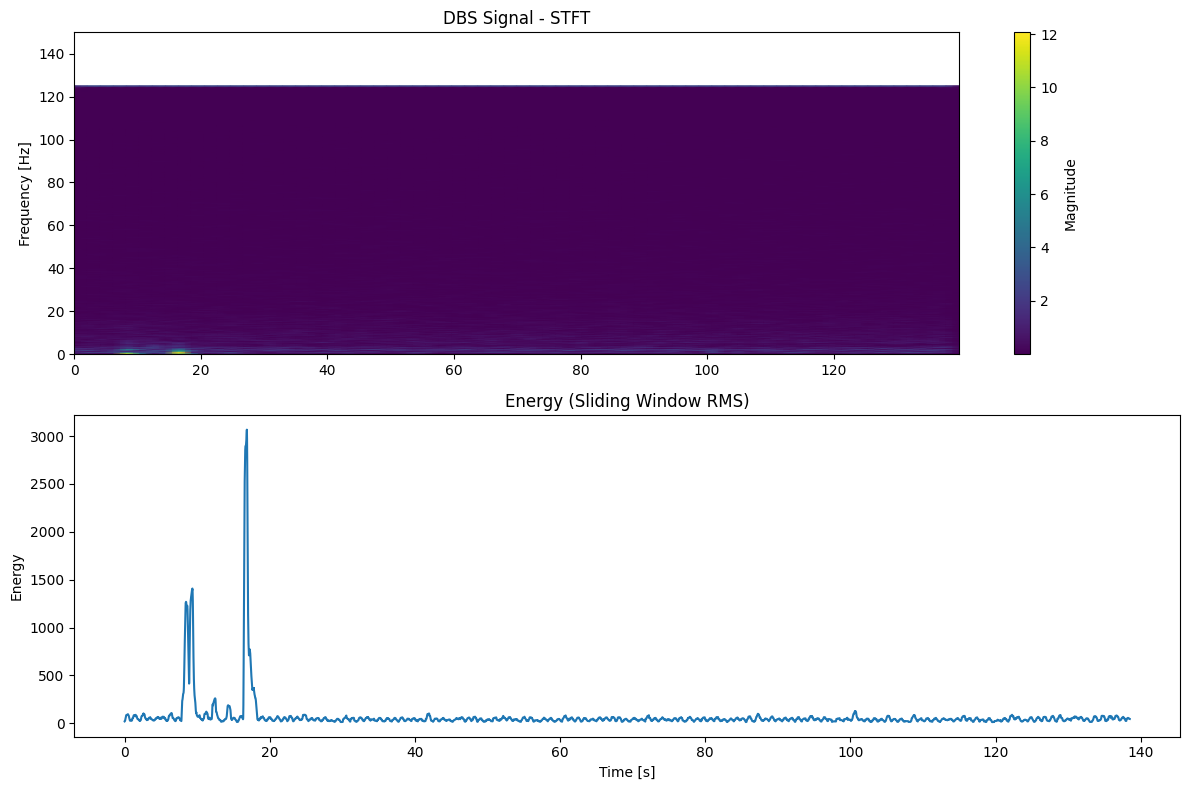

In [13]:
dbs_signal = dbs_data['TimeDomainData'].values
fs = 250  # Sampling frequency

# STFT parameters
nperseg = 1024
noverlap = 510

# Compute STFT
f, t, Zxx = stft(dbs_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)

# Compute energy (sliding window RMS)
window_size = int(0.5 * fs)  # 0.5 s window
energy = np.convolve(dbs_signal**2, np.ones(window_size)/window_size, mode='same')

# Plotting STFT and energy
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('DBS Signal - STFT')
plt.ylabel('Frequency [Hz]')
plt.ylim([0, 150])
plt.colorbar(label='Magnitude')

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(dbs_signal)) / fs, energy)
plt.title('Energy (Sliding Window RMS)')
plt.xlabel('Time [s]')
plt.ylabel('Energy')

plt.tight_layout()
plt.show()

EEG

In [14]:
eeg_data_small

<RawEEGLAB | eeg_example.set, 74 x 60000 (120.0 s), ~34.0 MiB, data loaded>

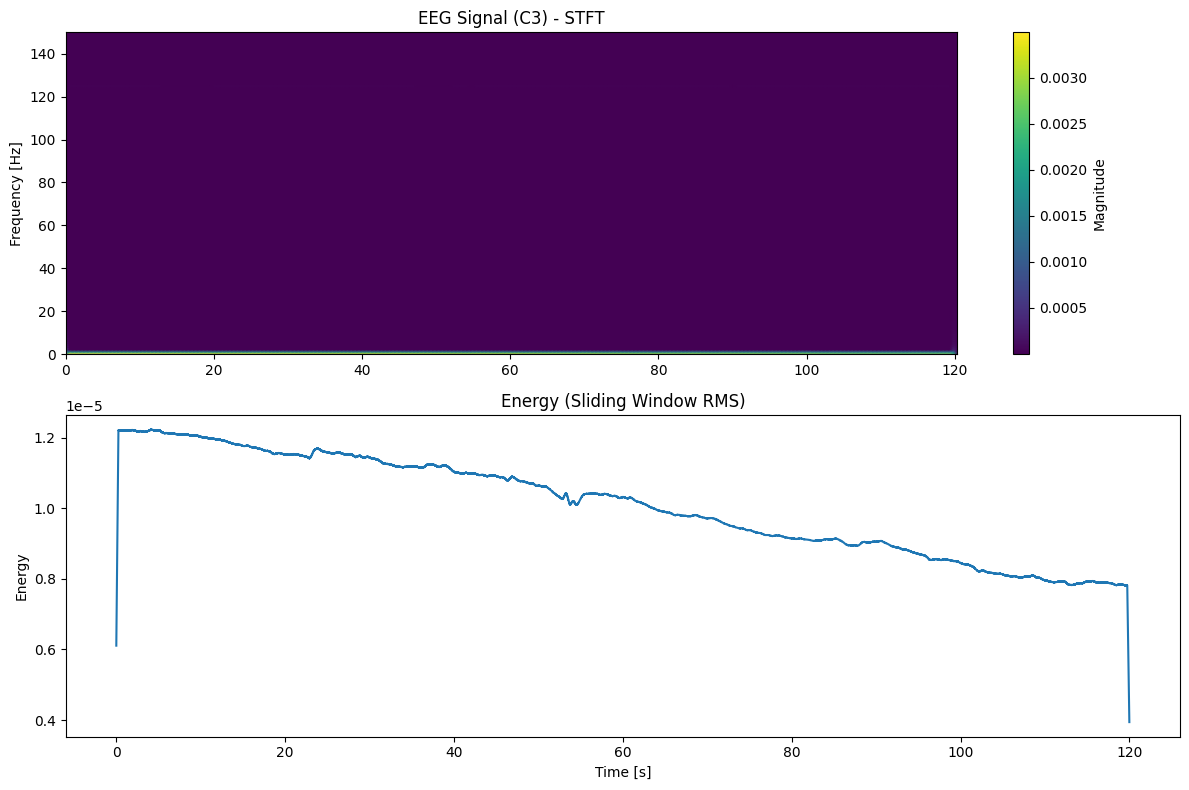

In [15]:
# Pick a representative EEG channel (e.g., C3)
channel_name = "C3"
channel_idx = eeg_data_small.ch_names.index(channel_name)
eeg_data_small = eeg_data_small.get_data(picks=[channel_idx])[0]
fs_eeg = 500

# STFT parameters
nperseg = 512
noverlap = 256

# Compute STFT
f_eeg, t_eeg, Zxx_eeg = stft(eeg_data_small, fs=fs_eeg, nperseg=nperseg, noverlap=noverlap)

# Compute energy (sliding window RMS)
window_size_eeg = int(0.5 * fs_eeg)  # 0.5 s window
energy_eeg = np.convolve(eeg_data_small**2, np.ones(window_size_eeg)/window_size_eeg, mode='same')

# Plotting STFT and energy
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.pcolormesh(t_eeg, f_eeg, np.abs(Zxx_eeg), shading='gouraud')
plt.title(f'EEG Signal ({channel_name}) - STFT')
plt.ylabel('Frequency [Hz]')
plt.ylim([0, 150])
plt.colorbar(label='Magnitude')

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(eeg_data_small)) / fs_eeg, energy_eeg)
plt.title('Energy (Sliding Window RMS)')
plt.xlabel('Time [s]')
plt.ylabel('Energy')

plt.tight_layout()
plt.show()


# Combination of Peak and Drop in EEG 
	1.	Peak detector → look for transient “edges”.
	2.	Sustained power drop detector → look for gradual drop in power envelope.

In [16]:
def detect_sync_eeg_combined(raw_eeg, freq_low, freq_high, decim, duration_sec=120,
                             drop_threshold=0.85, save_dir=None, log_file="sync_log.txt"):
    """
    Detects sync artifact in EEG using combined peak and drop detection in power envelope.

    Args:
        raw_eeg (mne.io.Raw): The raw EEG data object.
        freq_low (float): Lower bound of the frequency range.
        freq_high (float): Upper bound of the frequency range.
        decim (int): Decimation factor.
        duration_sec (int): Duration to analyze.
        drop_threshold (float): Relative drop threshold (e.g., 0.85 → 15% drop).
        save_dir (str): Directory to save plot.
        log_file (str): Log file path.

    Returns:
        peak_idx_fs (int): Detected peak index in EEG sampling frequency.
        drop_idx_fs (int): Detected drop index in EEG sampling frequency.
    """

    # Crop and filter EEG
    raw_cropped = raw_eeg.copy().crop(tmax=duration_sec)
    raw_filtered = raw_cropped.copy().filter(l_freq=freq_low, h_freq=freq_high)

    fs = raw_filtered.info["sfreq"]
    freqs = np.arange(freq_low, freq_high, 1)
    n_cycles = freqs / 1.5
    time_bandwidth = 4.0

    power = mne.time_frequency.tfr_multitaper(
        raw_filtered,
        picks="eeg",
        freqs=freqs,
        n_cycles=n_cycles,
        time_bandwidth=time_bandwidth,
        decim=decim,
        average=True,
        return_itc=False
    )

    power_band_sum = power.data.mean(axis=0).sum(axis=0)
    time_axis = np.arange(len(power_band_sum)) * decim / fs

    # --- Peak Detection ---
    peaks, peak_properties = find_peaks(power_band_sum, height=np.mean(power_band_sum) * 1.5)
    peak_idx_fs, peak_idx_s = None, None
    if len(peaks) > 0:
        highest_peak_idx = np.argmax(peak_properties["peak_heights"])
        peak_idx = peaks[highest_peak_idx]
        peak_idx_fs = peak_idx * decim
        peak_idx_s = peak_idx_fs / fs

    # --- Drop Detection ---
    drop_idx = None
    mean_power = np.mean(power_band_sum)
    for i in range(1, len(power_band_sum)):
        if power_band_sum[i] < drop_threshold * mean_power:
            drop_idx = i
            break
    drop_idx_fs = drop_idx * decim if drop_idx else None
    drop_idx_s = drop_idx_fs / fs if drop_idx_fs else None

    # --- Logging ---
    with open(log_file, "a") as log:
        log.write(f"EEG Sync Detection:\n")
        log.write(f"  Peak at {peak_idx_fs} samples ({peak_idx_s:.2f} s)\n" if peak_idx_fs else "  No peak detected.\n")
        log.write(f"  Drop at {drop_idx_fs} samples ({drop_idx_s:.2f} s)\n" if drop_idx_fs else "  No drop detected.\n")

    # --- Plot ---
    plt.figure(figsize=(10, 5))
    plt.plot(time_axis, power_band_sum, label="Power in Band (125 Hz)")
    if peak_idx_fs:
        plt.axvline(time_axis[peak_idx], color='r', linestyle='--', label=f'Peak @ {time_axis[peak_idx]:.2f}s')
    if drop_idx:
        plt.axvline(time_axis[drop_idx], color='g', linestyle='--', label=f'Drop @ {time_axis[drop_idx]:.2f}s')
    plt.xlabel('Time (s)')
    plt.ylabel('Power')
    plt.title('EEG Sync Detection - Combined Method')
    plt.legend()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/sync_detection_combined.png")

    plt.show()
    plt.close()

    return peak_idx_fs, drop_idx_fs

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.2e+02 - 1.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 120.00
- Lower transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 105.00 Hz)
- Upper passband edge: 130.00 Hz
- Upper transition bandwidth: 32.50 Hz (-6 dB cutoff frequency: 146.25 Hz)
- Filter length: 221 samples (0.111 s)

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`


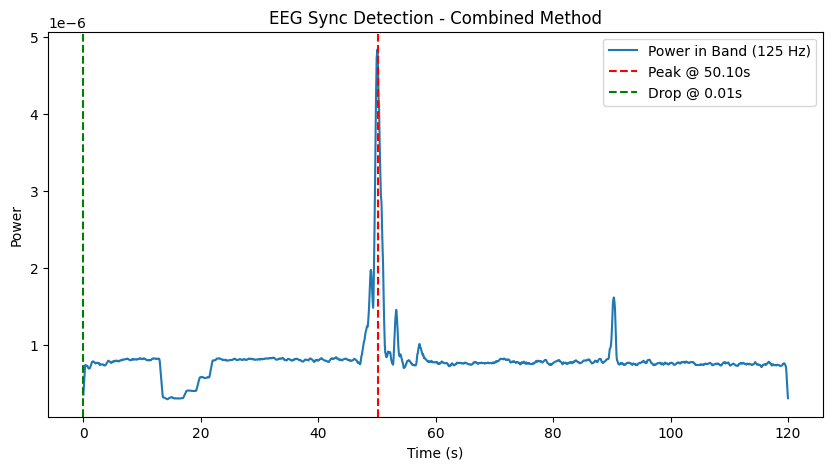

(np.int64(100210), 10)

In [17]:
# Example usage (uncomment and adapt for real use):
detect_sync_eeg_combined(eeg_data, 120, 130, decim=10, duration_sec=120)

Detect drop onset

In [18]:
def detect_drop_onset(raw_eeg, freq_low, freq_high, decim, cut_sec=1, smooth_window=301, threshold_factor=5, plot=False, save_dir=None):
    """
    Detect the onset of a drop in power_band_sum based on gradient.

    Parameters:
    - power_band_sum: np.ndarray
        The power time series.
    - fs: float
        Sampling frequency of the EEG data.
    - decim: int
        Decimation factor used in power computation.
    - cut_sec: float
        Seconds to exclude at start and end.
    - smooth_window: int
        Window length for Savitzky-Golay smoothing.
    - threshold_factor: float
        Multiplier for gradient threshold.
    - plot: bool
        If True, plot the detection.
    - save_dir: str or None
        Directory to save plot if desired.

    Returns:
    - drop_onset_idx: int
        Index of drop onset in power_band_sum.
    """


    raw_cropped = raw_eeg.copy().crop(tmax=120)  # crop to first 2 min, where the artifact should be present
    # Filter the raw data to remove low-frequency drifts and high-frequency noise
    raw_filtered = raw_cropped.copy().filter(l_freq=freq_low, h_freq=freq_high)  # Bandpass filter to the 120-130 Hz band
    # Get the sampling frequency
    fs = raw_filtered.info["sfreq"]
    # Define frequencies and wavelet parameters
    freqs = np.arange(freq_low, freq_high, 1)
    n_cycles = freqs / 1.5  # Use a balance between time and frequency resolution
    time_bandwidth = 4.0  # Adjust for a balance between time and frequency resolution
    # Compute TFR using multitaper
    power = mne.time_frequency.tfr_multitaper(
        raw_filtered,
        picks="eeg",
        freqs=freqs,
        n_cycles=n_cycles,
        time_bandwidth=time_bandwidth,
        n_jobs=1,  # Use parallel processing if supported
        decim=decim,  # Downsampling factor
        average=True,  # Average over epochs
        return_itc=False  # Do not compute inter-trial coherence
    )
    frequencies = power.freqs  # number of frequency rows
    # Extract the power values for the 125 Hz band (approximately 120-130 Hz)
    freq_band_mask = (frequencies >= 120) & (frequencies <= 130)
    # Extract the power values for the 125 Hz band (approximately 120-130 Hz)
    power_band = power.data[:, freq_band_mask, :]

    # Sum power across the selected band to create a time series
    power_band_sum = np.mean(power_band.sum(axis=0), axis=0)

    cut_samples = int((fs / decim) * cut_sec)

    # Smoothing
    smoothed = savgol_filter(power_band_sum, window_length=smooth_window, polyorder=3)

    # Gradient
    gradient = np.gradient(smoothed)

    # Threshold
    search_gradient = gradient[cut_samples:-cut_samples]
    threshold = np.mean(gradient) - threshold_factor * np.std(gradient)
    drop_onset_relative = np.where(search_gradient < threshold)[0][0]
    drop_onset_idx = drop_onset_relative + cut_samples

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(smoothed, label="Smoothed Power Band Sum")
        plt.axvline(drop_onset_idx, color="r", linestyle="--", label="Drop Onset")
        plt.xlabel("Samples")
        plt.ylabel("Power")
        plt.title("Drop Onset Detection via Gradient")
        plt.legend()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, "drop_onset_detection.png"))
        plt.show()

    return drop_onset_idx

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.2e+02 - 1.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 120.00
- Lower transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 105.00 Hz)
- Upper passband edge: 130.00 Hz
- Upper transition bandwidth: 32.50 Hz (-6 dB cutoff frequency: 146.25 Hz)
- Filter length: 221 samples (0.111 s)

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`


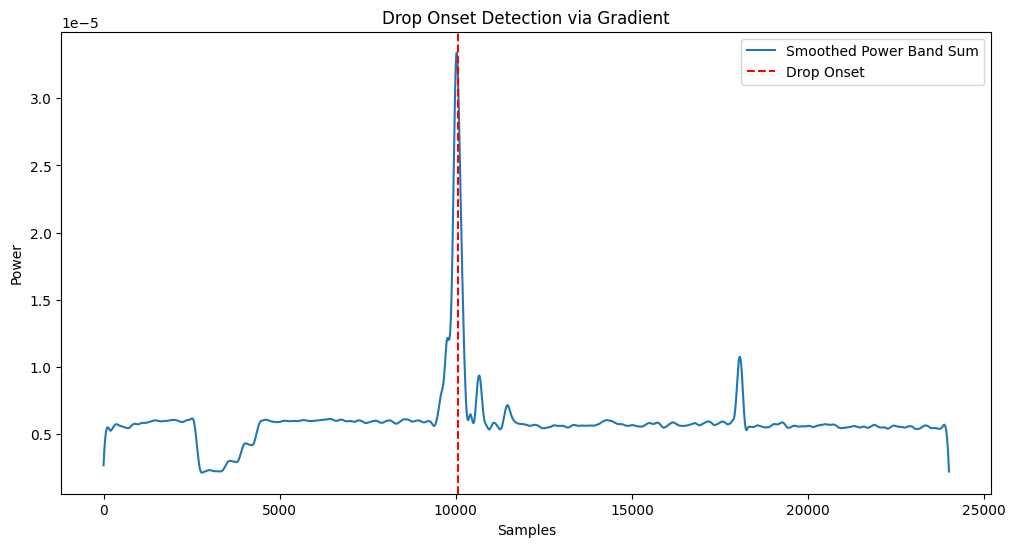

np.int64(10059)

In [19]:
detect_drop_onset(eeg_data, 120, 130, decim=10, cut_sec=1, smooth_window=301, threshold_factor=5, plot=True, save_dir=None)